In [1]:
import os
import torch
import wandb
from transformers import AutoTokenizer, ViTModel, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from tqdm import tqdm
import nltk
import warnings
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Андрей
[nltk_data]     гл\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Инициализация NLTK
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Андрей
[nltk_data]     гл\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Инициализация Weights & Biases
wandb.init(project="image-captioning", entity="balamytin-susu")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: balamytin (balamytin-susu). Use `wandb login --relogin` to force relogin


In [4]:
# Пути к директориям с изображениями и аннотациями
train_data_dir = "C:/Users/Андрей гл/OBUCHENIE/3 СЕМЕСТР/Нейросетевые технологии в задачах синтетических медиа/Практичкская 4/train2014"
val_data_dir = "C:/Users/Андрей гл/OBUCHENIE/3 СЕМЕСТР/Нейросетевые технологии в задачах синтетических медиа/Практичкская 4/val2014"

train_annotations_file = "C:/Users/Андрей гл/OBUCHENIE/3 СЕМЕСТР/Нейросетевые технологии в задачах синтетических медиа/Практичкская 4/annotations/captions_train2014.json"
val_annotations_file = "C:/Users/Андрей гл/OBUCHENIE/3 СЕМЕСТР/Нейросетевые технологии в задачах синтетических медиа/Практичкская 4/annotations/captions_val2014.json"

In [5]:
# Проверка доступности CUDA и выбор устройства
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA доступна. Используется GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("CUDA не доступна. Используется CPU.")

CUDA доступна. Используется GPU: NVIDIA GeForce RTX 3070 Ti


In [6]:
# Преобразования для изображений
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
# Инициализация токенизатора
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Установка pad_token для GPT2


In [8]:
# Определение класса датасета COCO
class CocoDataset(Dataset):
    def __init__(self, data_dir, annotations_file, transform=None, tokenizer=None, max_length=128, subset_size=None):
        self.data_dir = data_dir
        self.coco = COCO(annotations_file)
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.ids = list(self.coco.imgToAnns.keys())

        if subset_size is not None:
            self.ids = self.ids[:subset_size]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        captions = [ann['caption'] for ann in anns]

        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        image_path = os.path.join(self.data_dir, path)
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Используем первую подпись
        caption = captions[0]
        if self.tokenizer is not None:
            inputs = self.tokenizer(
                caption,
                return_tensors="pt",
                max_length=self.max_length,
                padding='max_length',
                truncation=True
            )
            caption_ids = inputs.input_ids.squeeze()
            attention_mask = inputs.attention_mask.squeeze()
        else:
            caption_ids = None
            attention_mask = None

        return image, caption_ids, attention_mask

In [18]:
# Гиперпараметры
subset_size = None  # Установите None для использования полного набора данных
batch_size = 8
epochs = 5  # Измените количество эпох по необходимости
learning_rate = 1e-4
max_length = 128

In [19]:
# Создание обучающего датасета и DataLoader
train_dataset = CocoDataset(
    data_dir=train_data_dir,
    annotations_file=train_annotations_file,
    transform=image_transform,
    tokenizer=tokenizer,
    max_length=max_length,
    subset_size=subset_size
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Установите num_workers >0 для Unix-систем

# Создание полного валидационного датасета
full_val_dataset = CocoDataset(
    data_dir=val_data_dir,
    annotations_file=val_annotations_file,
    transform=image_transform,
    tokenizer=tokenizer,
    max_length=max_length,
    subset_size=subset_size
)


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [20]:
# Разделение валидационного датасета на валидационный и тестовый наборы
val_size = int(0.5 * len(full_val_dataset))
test_size = len(full_val_dataset) - val_size
val_dataset, test_dataset = random_split(full_val_dataset, [val_size, test_size])

# DataLoader для валидационного набора
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# DataLoader для тестового набора
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Инициализация энкодера и декодера
encoder_name = 'google/vit-base-patch16-224'  # Выберите одну из предложенных архитектур
decoder_name = 'gpt2'  # Можно выбрать 'bert-base-uncased' или 'prajjwal1/bert-tiny'

image_encoder = ViTModel.from_pretrained(encoder_name)
decoder = GPT2LMHeadModel.from_pretrained(decoder_name)
decoder.resize_token_embeddings(len(tokenizer))

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50257, 768)

In [21]:
# Определение модели ImageCaptioningModel
class ImageCaptioningModel(torch.nn.Module):
    def __init__(self, image_encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.image_encoder = image_encoder
        self.decoder = decoder
        self.linear = torch.nn.Linear(image_encoder.config.hidden_size, decoder.config.n_embd)

    def forward(self, images, captions, attention_mask):
        # Извлечение признаков изображения
        image_outputs = self.image_encoder(pixel_values=images)
        image_embeds = image_outputs.last_hidden_state[:, 0, :]  # Берем [CLS] токен
        image_embeds = self.linear(image_embeds)  # Приводим размерность к размерности декодера
        image_embeds = image_embeds.unsqueeze(1)  # Добавляем временную размерность

        # Получение эмбеддингов подписи
        captions_embeds = self.decoder.transformer.wte(captions)  # Встраивание токенов

        # Объединение эмбеддингов изображения и подписи
        inputs_embeds = torch.cat((image_embeds, captions_embeds[:, :-1, :]), dim=1)

        # Обновление attention_mask
        attention_mask = torch.cat((torch.ones((attention_mask.size(0), 1), device=attention_mask.device), attention_mask[:, :-1]), dim=1)

        # Прогон через декодер
        outputs = self.decoder(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=captions)
        return outputs

In [22]:

# Инициализация модели
model = ImageCaptioningModel(image_encoder, decoder).to(device)


In [23]:
# Инициализация оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [24]:
# Вывод размеров датасетов для проверки
print(f"Количество обучающих изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(val_dataset)}")
print(f"Количество тестовых изображений: {len(test_dataset)}")


Количество обучающих изображений: 82783
Количество валидационных изображений: 20252
Количество тестовых изображений: 20252


In [25]:
# Проверка загрузки нескольких батчей
print("\nПроверка загрузки нескольких батчей:")
for i, (images, captions, attention_mask) in enumerate(train_dataloader):
    print(f"Батч {i+1}: изображения {images.size()}, подписи {captions.size()}, маска {attention_mask.size()}")
    if i >= 2:
        break


Проверка загрузки нескольких батчей:
Батч 1: изображения torch.Size([8, 3, 224, 224]), подписи torch.Size([8, 128]), маска torch.Size([8, 128])
Батч 2: изображения torch.Size([8, 3, 224, 224]), подписи torch.Size([8, 128]), маска torch.Size([8, 128])
Батч 3: изображения torch.Size([8, 3, 224, 224]), подписи torch.Size([8, 128]), маска torch.Size([8, 128])


In [26]:
# Цикл обучения
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Эпоха {epoch+1}/{epochs}", total=len(train_dataloader))

    for batch_idx, (images, captions, attention_mask) in enumerate(progress_bar):
        try:
            # Перемещение данных на устройство
            images = images.to(device)
            captions = captions.to(device)
            attention_mask = attention_mask.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прогон через модель
            outputs = model(images, captions, attention_mask)
            loss = outputs.loss

            # Обратное распространение ошибки
            loss.backward()
            optimizer.step()

            # Суммирование потерь
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)

            # Обновление прогресс-бара
            progress_bar.set_postfix({"Потеря": f"{avg_loss:.4f}"})

            # Логирование в Weights & Biases
            wandb.log({
                "Эпоха": epoch + 1,
                "Батч": batch_idx + 1,
                "Потеря": avg_loss,
            })

            # Мониторинг использования GPU каждые 10 батчей
            if (batch_idx + 1) % 10 == 0:
                if torch.cuda.is_available():
                    allocated = torch.cuda.memory_allocated(device) / 1024**2  # в МБ
                    reserved = torch.cuda.memory_reserved(device) / 1024**2  # в МБ
                    progress_bar.set_postfix({
                        "Потеря": f"{avg_loss:.4f}",
                        "GPU Allocated (MB)": f"{allocated:.2f}",
                        "GPU Reserved (MB)": f"{reserved:.2f}"
                    })
                    wandb.log({
                        "GPU Allocated (MB)": allocated,
                        "GPU Reserved (MB)": reserved,
                    })
        except Exception as e:
            print(f"Ошибка при обработке батча {batch_idx + 1}: {e}")
            continue  # Пропустить текущий батч и продолжить обучение

    # Валидация после каждой эпохи
    model.eval()
    val_loss = 0
    progress_bar_val = tqdm(val_dataloader, desc=f"Эпоха {epoch+1}/{epochs} (Валидация)", total=len(val_dataloader))
    with torch.no_grad():
        for batch_idx, (images, captions, attention_mask) in enumerate(progress_bar_val):
            try:
                images = images.to(device)
                captions = captions.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(images, captions, attention_mask)
                loss = outputs.loss
                val_loss += loss.item()
                avg_val_loss = val_loss / (batch_idx + 1)

                progress_bar_val.set_postfix({"Валидационная потеря": f"{avg_val_loss:.4f}"})
            except Exception as e:
                print(f"Ошибка при обработке валидационного батча {batch_idx + 1}: {e}")
                continue  # Пропустить текущий батч и продолжить валидацию

    avg_val_loss = val_loss / len(val_dataloader)
    wandb.log({
        "Эпоха": epoch + 1,
        "Валидационная потеря": avg_val_loss,
    })

    # Сохранение модели после каждой эпохи как артефакта WandB
    model_save_path = f"image_captioning_model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Создание артефакта WandB
    artifact = wandb.Artifact(f"model_epoch_{epoch+1}", type="model")
    artifact.add_file(model_save_path)
    wandb.log_artifact(artifact)

    print(f"Эпоха {epoch+1} завершена. Валидационная потеря: {avg_val_loss:.4f}")

print("Обучение завершено.")

Эпоха 1/5 (Валидация): 100%|██████████████████████████| 2532/2532 [07:00<00:00,  6.03it/s, Валидационная потеря=0.3066]


Эпоха 1 завершена. Валидационная потеря: 0.3066


Эпоха 2/5 (Валидация): 100%|██████████████████████████| 2532/2532 [06:20<00:00,  6.66it/s, Валидационная потеря=0.2963]


Эпоха 2 завершена. Валидационная потеря: 0.2963


Эпоха 3/5 (Валидация): 100%|██████████████████████████| 2532/2532 [06:09<00:00,  6.85it/s, Валидационная потеря=0.2932]


Эпоха 3 завершена. Валидационная потеря: 0.2932


Эпоха 4/5 (Валидация): 100%|██████████████████████████| 2532/2532 [06:21<00:00,  6.63it/s, Валидационная потеря=0.2969]


Эпоха 4 завершена. Валидационная потеря: 0.2969


Эпоха 5/5 (Валидация): 100%|██████████████████████████| 2532/2532 [06:11<00:00,  6.82it/s, Валидационная потеря=0.3072]


Эпоха 5 завершена. Валидационная потеря: 0.3072
Обучение завершено.


In [27]:
def evaluate_model(model, dataloader, tokenizer, device):
    model.eval()
    references = []
    hypotheses = []
    smoothie = SmoothingFunction().method4
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    with torch.no_grad():
        for batch_idx, (images, captions, attention_mask) in enumerate(tqdm(dataloader, desc="Оценка модели")):
            images = images.to(device)
            # captions и attention_mask используются только для получения реальных аннотаций

            # Извлечение признаков изображения
            image_outputs = model.image_encoder(pixel_values=images)
            image_embeds = image_outputs.last_hidden_state[:, 0, :]  # Берём [CLS] токен
            image_embeds = model.linear(image_embeds)  # Приводим размерность к размерности декодера
            image_embeds = image_embeds.unsqueeze(1)  # Добавляем временную размерность

            # Создание attention_mask для генерации
            # Поскольку image_embeds имеет размер (batch_size, 1, embedding_dim), attention_mask будет (batch_size, 1)
            attention_mask_gen = torch.ones((images.size(0), 1), device=device, dtype=torch.long)

            # Генерация описаний
            generated_ids = model.decoder.generate(
                inputs_embeds=image_embeds,
                attention_mask=attention_mask_gen,
                max_length=max_length,
                num_beams=5,
                early_stopping=True,
                pad_token_id=tokenizer.eos_token_id  # Явно указываем pad_token_id
            )

            # Декодирование предсказанных и реальных описаний
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(captions, skip_special_tokens=True)

            for ref, hyp in zip(decoded_labels, decoded_preds):
                references.append([nltk.word_tokenize(ref.lower())])
                hypotheses.append(nltk.word_tokenize(hyp.lower()))
                
                # Вычисление ROUGE для каждого примера
                scores = rouge_scorer_instance.score(ref, hyp)
                for key in rouge_scores.keys():
                    rouge_scores[key].append(scores[key].fmeasure)

    # Вычисление BLEU
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)

    # Вычисление средних ROUGE
    avg_rouge_scores = {key: sum(values) / len(values) for key, values in rouge_scores.items()}

    # Вычисление SPICE (требует установки Java и SPICE)
    # Убедитесь, что путь к spice-1.0.jar указан корректно
    try:
        from pycocoevalcap.spice.spice import Spice
        spice = Spice(jar_path='C:/path/to/spice-1.0.jar')  # Замените на корректный путь
        spice_score, _ = spice.compute_score(
            {i: [ref[0]] for i, ref in enumerate(references)},
            {i: [hyp] for i, hyp in enumerate(hypotheses)}
        )
    except Exception as e:
        print(f"Ошибка при вычислении SPICE: {e}")
        spice_score = None

    return bleu_score, avg_rouge_scores, spice_score

In [28]:
# Оценка на тестовом наборе данных
bleu, rouge, spice = evaluate_model(model, test_dataloader, tokenizer, device)
print(f"BLEU score: {bleu:.4f}")
print(f"ROUGE scores: {rouge}")
print(f"SPICE score: {spice:.4f}" if spice is not None else "SPICE не был вычислен")


Оценка модели: 100%|███████████████████████████████████████████████████████████████| 2532/2532 [38:43<00:00,  1.09it/s]


Ошибка при вычислении SPICE: Spice.__init__() got an unexpected keyword argument 'jar_path'
BLEU score: 0.0008
ROUGE scores: {'rouge1': 0.27628972376925276, 'rouge2': 0.007587620043864583, 'rougeL': 0.22494062777966506}
SPICE не был вычислен


In [29]:
# Логирование метрик в Weights & Biases
wandb.log({
    "BLEU score (тестовый набор)": bleu,
    "ROUGE-1 (тестовый набор)": rouge.get('rouge1', 0),
    "ROUGE-2 (тестовый набор)": rouge.get('rouge2', 0),
    "ROUGE-L (тестовый набор)": rouge.get('rougeL', 0),
    "SPICE (тестовый набор)": spice if spice is not None else 0,
})

In [30]:
# Сохранение финальной модели как артефакта WandB
final_model_path = "models/image_captioning_model_final.pth"
os.makedirs(os.path.dirname(final_model_path), exist_ok=True)
torch.save(model.state_dict(), final_model_path)
print(f"Модель сохранена: {final_model_path}")

artifact_final = wandb.Artifact("model_final", type="model")
artifact_final.add_file(final_model_path)
wandb.log_artifact(artifact_final)
print(f"Финальная модель сохранена и загружена как артефакт WandB: {final_model_path}")


Модель сохранена: models/image_captioning_model_final.pth
Финальная модель сохранена и загружена как артефакт WandB: models/image_captioning_model_final.pth


In [31]:
# Загрузка модели
model = ImageCaptioningModel(image_encoder, decoder)
model.load_state_dict(torch.load(final_model_path))
model.to(device)
model.eval()

ImageCaptioningModel(
  (image_encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(

In [32]:
import matplotlib.pyplot as plt
import torch


In [33]:
# Функция для визуализации результатов
def visualize_results(model, test_dataset, tokenizer, device, num_examples=5, max_length=128):
    model.eval()
    with torch.no_grad():
        for i in range(num_examples):
            image, caption_ids, _ = test_dataset[i]
            image_input = image.unsqueeze(0).to(device)

            # Извлечение признаков изображения
            image_outputs = model.image_encoder(pixel_values=image_input)
            image_embeds = image_outputs.last_hidden_state[:, 0, :]  # Берем [CLS] токен
            image_embeds = model.linear(image_embeds)  # Приводим размерность к размерности декодера
            image_embeds = image_embeds.unsqueeze(1)  # Добавляем временную размерность

            # Создание attention_mask для генерации
            attention_mask_gen = torch.ones((1, 1), device=device, dtype=torch.long)

            # Генерация описания
            generated_ids = model.decoder.generate(
                inputs_embeds=image_embeds,
                attention_mask=attention_mask_gen,
                max_length=max_length,
                num_beams=5,
                early_stopping=True,
                pad_token_id=tokenizer.eos_token_id  # Явно указываем pad_token_id
            )
            generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            real_caption = tokenizer.decode(caption_ids, skip_special_tokens=True)

            # Вывод результатов
            plt.imshow(image.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.show()
            print(f"Реальное описание: {real_caption}")
            print(f"Сгенерированное описание: {generated_caption}\n")

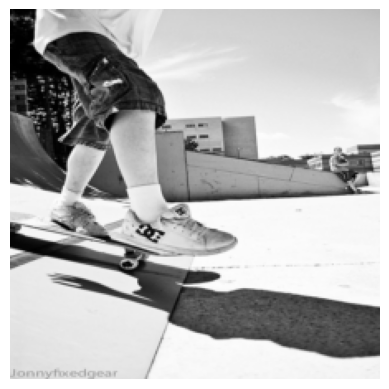

Реальное описание: A person on a skateboard rides down a ramp.
Сгенерированное описание:  person on skate on sidewalk to aboard



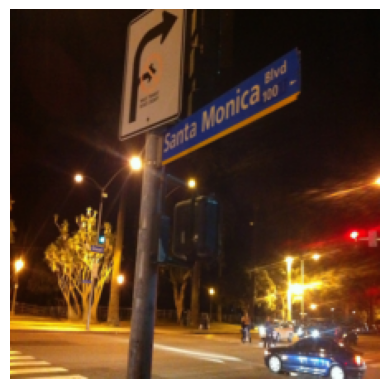

Реальное описание: A street sign that is on the side of a pole.
Сгенерированное описание:  street and signs a light a and street and



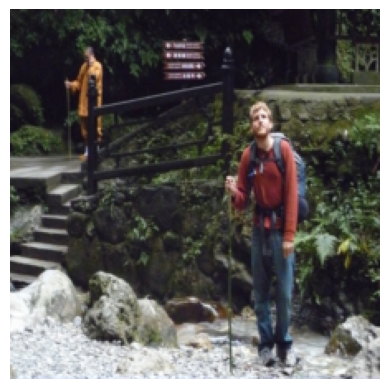

Реальное описание: A man holding a stick standing next to a  green hillside.
Сгенерированное описание:  man next a standing next a standing.



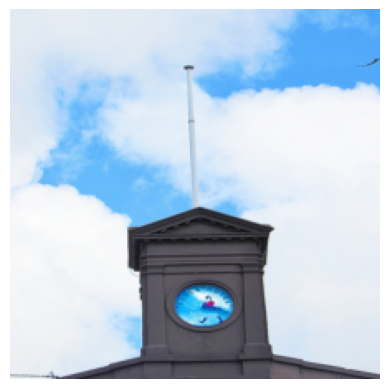

Реальное описание: A large clock tower on top of a church building.
Сгенерированное описание:  clock the of church the is and the is



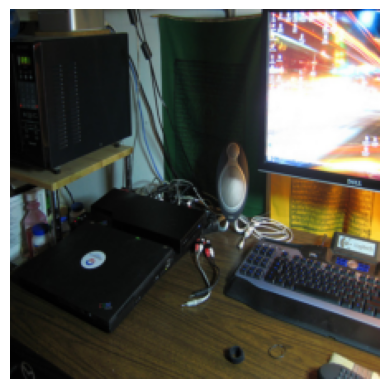

Реальное описание: A laptop and a keyboard on a desk.
Сгенерированное описание:  desk a a a a a a a a a a a a a a a and keyboard



In [34]:
# Вызов функции для визуализации
visualize_results(model, test_dataset, tokenizer, device, num_examples=5, max_length=128)